# Spectral Botany proof of concept

By Tim Hackwood

This Notebook demonstrates techniques for using spectral diversity variables (coefficient of variance and spectral convex hulls) to predict Australian Broad Vegetation Groups (BVGs) in the the Southern Brigalow Belt bioregion, Queensland.

Methodology for raster segmentation and clustering adapted from Scarth (2022) https://github.com/petescarth/segmentation-example, with pyshepseg https://github.com/ubarsc/pyshepseg to segment the large dataset.

In [1]:
# Imports
from rios import applier, cuiprogress
import geopandas as gpd
from shapely import box
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
import os
import galah
from osgeo import gdal, ogr, gdalconst, osr
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import joblib
from rios import rat
from rios import applier, cuiprogress
from rios import ratapplier
from pyshepseg import tiling
from pyshepseg import tilingstats
from pyshepseg import utils
from pystac_client import Client
import matplotlib.pyplot as plt
import folium
from skimage import exposure
import branca
import numpy as np
from dotenv import load_dotenv
import boto3

# Create a session using the specified AWS profile
session = boto3.Session(profile_name='default')

# Get credentials from the session
credentials = session.get_credentials()
aws_access_key_id = credentials.access_key
aws_secret_access_key = credentials.secret_key
aws_session_token = credentials.token  # Only needed if using temporary credentials

# Set GDAL configuration options for S3 access
gdal.SetConfigOption('AWS_ACCESS_KEY_ID', aws_access_key_id)
gdal.SetConfigOption('AWS_SECRET_ACCESS_KEY', aws_secret_access_key)
if aws_session_token:
    gdal.SetConfigOption('AWS_SESSION_TOKEN', aws_session_token)

# Load environment variables from .env file
load_dotenv()

ala_username = os.getenv('DB_USERNAME')

# Set the working directory to SpectralBotany
os.chdir("/home/tim/rubella/scripts/SpectralBotany")

# Config for Atlas Living Australia APO
galah.galah_config(email = ala_username, atlas = "Australia")

AOI = "data/SpectralBotanyTest.gpkg"
Layer = "BrigalowBeltAOI"

# FIles for PCA and Segment outputs
RASTER_PC = "data/Sentinel/Sentinel_brigalow_PCA_e24_v2.tif"

def warpToMatch(srcName, matchName, resampleAlg='nearest', tmpdir=None):
    """
    Function virtually warps raster to resolution and projection of matchName.
    Returns a .vrt with filename srcName_warp.vrt.
    """
    print(srcName, matchName)
    # Make the output name
    dstName = srcName.replace('.tif', '_warp.vrt')

    if tmpdir is not None:
        dstName = os.path.join(tmpdir, os.path.basename(dstName))

    # Get the match file info
    matchFile =  gdal.Open(matchName, gdalconst.GA_ReadOnly)
    dstSRS = matchFile.GetProjection()
    dstGeoTrans = matchFile.GetGeoTransform()
    outputBounds = (dstGeoTrans[0],
                    dstGeoTrans[3] + dstGeoTrans[5] * matchFile.RasterYSize,
                    dstGeoTrans[0] + dstGeoTrans[1] * matchFile.RasterXSize,
                    dstGeoTrans[3])
    matchFile = None
    # Do the warp
    ds = gdal.Warp(dstName, srcName,
                   dstSRS=dstSRS,
                   format='VRT',
                   targetAlignedPixels=False,
                   outputBounds=outputBounds,
                   xRes=abs(dstGeoTrans[1]),
                   yRes=abs(dstGeoTrans[5]),
                   resampleAlg=resampleAlg,
                   multithread=True, #outputType=gdal.GDT_Float32,
                   overviewLevel=None)
    ds = None
    # Return the output name
    return dstName

In [17]:
import shutil

# Make a backup copy of the segment file

shutil.copy("/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_v2_segs_500.kea", "/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_v2_segs_500.kea.bak")

'/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_v2_segs_500.kea.bak'

<Axes: >

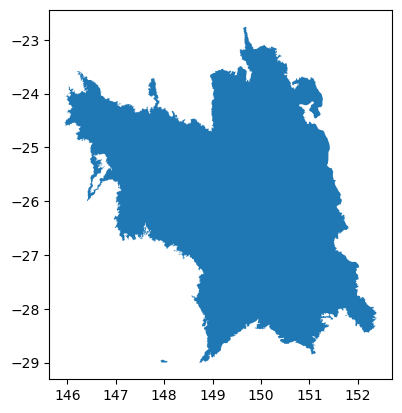

In [3]:
# Load AOI
brigalow = gpd.read_file(AOI, layer=Layer)
# Reproject to WGS84 for STAC API
brigalow.to_crs(4326, inplace=True)
# Plot to check everything looks ok
brigalow.plot()

## Plotting functions

In [28]:
def plot_rgb_to_html(input_tif, output_html, zoom=8, nodata=0, bandorder=[1, 2, 3], show=True):
    """
    Warp tif to wgs84, normalize data and stretch autimatically, and create a folium map with the raster overlay 
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first three bands
        data = src.read(bandorder).astype(np.float32)
        # Identify the no-data values
        no_data_mask = np.all(data == nodata, axis=0)
        # Normalize data to [0, 1] for each band before applying CLAHE
        data_normalized = np.array([exposure.rescale_intensity(band, in_range=(band.min(), band.max()), out_range=(0, 1)) for band in data])
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = np.array([exposure.equalize_adapthist(band, clip_limit=0.03) for band in data_normalized])
        # Reshape data for plotting
        data = reshape_as_image(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data = np.dstack((data, alpha_channel))
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom)

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

In [6]:
def plot_thematic_to_html(input_tif, output_html, zoom=8, nodata=0, cmap='viridis', legend_range=None, show=False):
    """
    Warp tif to wgs84, normalize data and stretch automatically, and create a folium map with the raster overlay.
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, xRes=320, yRes=320, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first band
        data = src.read(1).astype(np.float32)
        # Identify the no-data values
        no_data_mask = (data == nodata)
        # Apply quantile stretch only to non no-data values
        valid_data = data[~no_data_mask]
        p2, p98 = np.percentile(valid_data, (2, 98))
        data_stretched = exposure.rescale_intensity(data, in_range=(p2, p98), out_range=(0, 1))
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = exposure.equalize_adapthist(data_stretched, clip_limit=0.03) 
        # Apply colormap
        cmap = plt.get_cmap(cmap)
        data_colored = cmap(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data_colored[..., -1] = alpha_channel
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom,
                   )

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data_colored,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Determine legend range
    legend_min = legend_range[0] if legend_range else p2
    legend_max = legend_range[1] if legend_range else p98

    # Add a legend
    colormap = branca.colormap.LinearColormap(
        colors=[cmap(i) for i in range(cmap.N)],
        vmin=legend_min,
        vmax=legend_max,
        caption='Legend'
    )
    colormap.add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

## Stack with indices and get PCA for segmentation

The 6 spectral bands are stacked with NDVI and NDWI indices and ratios of every band combination

A PCA tiff is produced based on this data stack, then segmented.

In [4]:
# New version using seasonal Sentinel 2

def all_ratios(sampleData):
    # Function that takes a 3D array of bands and calculates the ratio of each band to every other band
    numBands = sampleData.shape[0]
    clippedData = np.clip(sampleData, 0, None).astype(float)
    # Get indices of upper triangle of the array
    i, j = np.triu_indices(numBands, 1)
    # Calculate the ratio of each band to every other band
    ratio_arr = (clippedData[i]-clippedData[j])/(clippedData[i]+clippedData[j]+np.finfo(float).eps)
    # Concatenate sampleData and reshaped ratio_arr
    sampleData = np.concatenate((sampleData,ratio_arr.reshape((-1,) + sampleData.shape[1:])), axis=0)
    
    return sampleData

# Calculate the bounding box of brigalow (Landsat imagery is in Albers)
brigalow.to_crs(epsg=3577, inplace=True)
bbox = brigalow.total_bounds

indata = []

# Tern sentinel 2 imagery
images = ["/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202409202411_abma2_brig.tif"] 

for rast in images:
    with rasterio.open(rast) as src:
        
        # Open a subsampled version of the image
        out_height = int(src.height / 50)
        out_width = int(src.width / 50)

        # Read the subsampled data from src using the bounding box
        img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
        img = all_ratios(img)
        inshape = img.shape
        
        # Calculate NDVI and NDWI
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        indata.append(stack)
        
VIs = ["/home/tim/dentata/outputs/brigalow_ndvistats.tif",
        "/home/tim/dentata/outputs/brigalow_ndwistats.tif"]
        
for vi in VIs:
    with rasterio.open(vi) as src:
        # Open a subsampled version of the image
        out_height = int(src.height / 50)
        out_width = int(src.width / 50)

        # Read the subsampled data from src using the bounding box
        img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
    
        
        indata.append(img)
    
        
# Make one big stack of data        
datastack = np.vstack(indata)

print(datastack.shape)


(35, 1391, 1153)


In [5]:
# Get indicies and fit the PCA

N_COMPONENTS = 3 # Change depending on variance results.

# Reshape stack to 2D
scale = np.reshape(datastack, (datastack.shape[0], -1))

# Delete unneeded variables
del img
del ndvi
del ndwi

# Rescale with robust scaler    
scaler = RobustScaler()
stack_scale = scaler.fit_transform(scale.T)
# Save the scaler
joblib.dump(scaler, './stack_scaler.pkl')
print(stack_scale.shape)

del scale

# Fit the PCA
pca = PCA(n_components=N_COMPONENTS, svd_solver='full', whiten=True)
pca.fit(stack_scale)
# Print the variance and save the PCA
sumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained: {sumvar}")
joblib.dump(pca, './pca.pkl')

# Transform the data to byte scale and save
pcaData = pca.transform(stack_scale).T
byteScale = np.percentile(pcaData,[0.001,99.999],axis=1)
joblib.dump(byteScale, './byteScale.pkl')

(1603823, 35)
Variance explained: [0.68423708 0.9253168  0.9570422 ]


['./byteScale.pkl']

In [8]:
# Apply the PCA to the full image and mask to Brigalow AOI
def _applyPCA(info, inputs, outputs, otherargs):
    """
    Apply PCA to full resolution dataset.
    """
    # Open the images
    s2 = inputs.inlist
    inshape = s2[0].shape
    aoi = inputs.aoi

    datastack = []

    for img in s2:

        img = all_ratios(img)
        
        inshape = img.shape        
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        datastack.append(stack)
        
    for vi in inputs.VIs:
        
        datastack.append(vi)
            
    stack = np.vstack(datastack)

    scaled_stack = np.reshape(stack, (stack.shape[0], -1)).astype('float32').T

    # Apply the PCA    
    pc = otherargs.pca.transform(otherargs.scaler.transform(scaled_stack))
    # Rescale to 16bit
    pc = np.round(np.clip(1.0 + 65534.0
                        * (pc-otherargs.bytescale[0])
                        / (otherargs.bytescale[1]-otherargs.bytescale[0])
                        ,1,65535))
        
    # Reshape the output
    pc = np.reshape(pc.T,(pc.shape[1],inshape[1],inshape[2]))
    # Mask the output for no data
    pc[:,np.any(stack == otherargs.noData,axis=0)] = 0
    pc[:, np.any(aoi == 0, axis=0)] = 0 # mask to the AOI
    outputs.pc =  pc.astype(np.uint16)

# Get the no data value
ds = gdal.Open("/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202409202411_abma2_brig.tif")
noData = ds.GetRasterBand(1).GetNoDataValue()
    
# Create the RIOS file objects
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

# Setup the IO
infiles.inlist = ["/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202409202411_abma2_brig.tif"]
infiles.VIs = ["/home/tim/dentata/outputs/brigalow_ndvistats.tif",
                "/home/tim/dentata/outputs/brigalow_ndwistats.tif"]
infiles.aoi = "data/SpectralBotanyTest.gpkg"

outfiles.pc = RASTER_PC

# Get the otherargs
otherargs = applier.OtherInputs()
otherargs.pca = joblib.load("pca.pkl")
otherargs.scaler = joblib.load("stack_scaler.pkl")
otherargs.bytescale = joblib.load("byteScale.pkl")
otherargs.noData = noData

# Controls for the processing   
controls = applier.ApplierControls()
controls.vectorlayer = "BrigalowBeltAOI"
controls.setBurnValue = 1
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(0) #  nodata
controls.progress = cuiprogress.CUIProgressBar()
controls.setFootprintType("INTERSECTION")
controls.setResampleMethod("near")
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                                "ZLEVEL=9",
                                "PREDICTOR=2",
                                "BIGTIFF=YES",
                                "TILED=YES",
                                "INTERLEAVE=BAND",
                                "NUM_THREADS=ALL_CPUS",
                                "BLOCKXSIZE=512",
                                "BLOCKYSIZE=512"])

# Set concurrency depending on system
conc = applier.ConcurrencyStyle(numReadWorkers=3,
                                numComputeWorkers=2,
                                computeWorkerKind="CW_THREADS",
                                readBufferPopTimeout=120,
                                computeBufferPopTimeout=120
                                )

controls.setConcurrencyStyle(conc)

# Run the function
print("Processing PCA")
applier.apply(_applyPCA, infiles, outfiles, otherargs, controls=controls)   

Processing PCA


## Segment the PCA

In [9]:
SEGMENT_SIZE = 500 # Approximately 5 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 3 # Number of PCA components

NDVI =  "/home/tim/dentata/outputs/brigalow_ndvistats.tif"
NDWI = "/home/tim/dentata/outputs/brigalow_ndwistats.tif"

RASTER_SEG = RASTER_PC.replace(".tif", f"_segs_{SEGMENT_SIZE}.kea")

print(RASTER_SEG)

data/Sentinel/Sentinel_brigalow_PCA_e24_v2_segs_500.kea


In [10]:
SEGMENT_SIZE = 500 # Approximately 5 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 3 # Number of PCA components

NDVI =  "/home/tim/dentata/outputs/brigalow_ndvistats.tif"
NDWI = "/home/tim/dentata/outputs/brigalow_ndwistats.tif"

RASTER_SEG = RASTER_PC.replace(".tif", f"_segs_{SEGMENT_SIZE}.kea")


# Segment using the tiled version
print('Segmenting')
tiledSegResult = tiling.doTiledShepherdSegmentation(RASTER_PC, RASTER_SEG,
            minSegmentSize=SEGMENT_SIZE, numClusters=64,
            bandNumbers=None, subsamplePcnt=None,
            maxSpectralDiff='auto', spectDistPcntile=25,
            imgNullVal=0, fourConnected=False, verbose=True,
            simpleTileRecode=False, outputDriver='KEA', kmeansObj=None)
           
# Do histogram, stats and colour table on final output file.
print('Adding Histogram, Stats and Colour Table')
outDs = gdal.Open(RASTER_SEG, gdal.GA_Update)
hist = tiling.calcHistogramTiled(outDs, tiledSegResult.maxSegId, writeToRat=True)
band = outDs.GetRasterBand(1)
utils.estimateStatsFromHisto(band, hist)
utils.writeRandomColourTable(band, tiledSegResult.maxSegId+1)
del outDs

# Add the original Image Stats
print('Adding Image Stats')
for imgbandnum in range(1,N_COMPONENTS+1):
    statsSelection = [
        ('pca_Band_{}_mean'.format(imgbandnum), 'mean'),
        ('pca_Band_{}_std'.format(imgbandnum), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(RASTER_PC, imgbandnum, RASTER_SEG,statsSelection)

# Add the index stats
print('Adding NDVI Stats')
ndvistats = ["median", "stddev", "5th", "25th", "75th", "95th"]
for i, statband in enumerate(ndvistats):
    statsSelection = [
        ('ndvi_{}_mean'.format(statband), 'mean'),
        ('ndvi_{}_std'.format(statband), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(NDVI, i+1, RASTER_SEG,statsSelection)
    
# Add the index stats
print('Adding NDWI Stats')
ndwistats = ["median", "stddev", "5th", "25th", "75th", "95th"]
for i, statband in enumerate(ndwistats):
    statsSelection = [
        ('ndWi_{}_mean'.format(statband), 'mean'),
        ('ndWi_{}_std'.format(statband), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(NDWI, i+1, RASTER_SEG,statsSelection)
    

# Export the segmentation as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.id = RASTER_SEG.replace('.kea', '_id.tif')
outfiles.rgb = RASTER_SEG.replace('.kea', '_rgb.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.round(rat.readColumn(infiles.image, f'pca_Band_{i}_mean')).astype(np.uint16))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    outputs.id = data.reshape((1,) + inputs.image.shape[1:]).astype(np.uint32)
    outputs.rgb = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Segmenting
Starting tiled segmentation
KMeans of whole raster 91.03 seconds
Subsample Percentage=0.02
Found 378 tiles, with 21 rows and 18 cols

Doing tile 1 of 378: row=0, col=0
Kmeans, in 0.5 seconds
Found 0 clumps, in 0.8 seconds
Eliminated 0 single pixels, in 2.3 seconds
Eliminated 0 segments, in 1.8 seconds
Final result has 0 segments

Doing tile 2 of 378: row=0, col=1
Kmeans, in 0.5 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 3 of 378: row=0, col=2
Kmeans, in 0.4 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 4 of 378: row=0, col=3
Kmeans, in 0.4 seconds
Found 0 clumps, in 0.0 seconds
Eliminated 0 single pixels, in 0.0 seconds
Eliminated 0 segments, in 0.1 seconds
Final result has 0 segments

Doing tile 5 of 378: row=0, col=4
Kmeans, in 0.4 seconds
Found 

In [11]:
# Calculate the coefficient of variance for each PCA band and add to the segmentation file

def variation(info, inputs, outputs):
    outputs.vegclass.pca1_var = np.where(inputs.vegclass.pca_Band_1_mean > 0, inputs.vegclass.pca_Band_1_std  / inputs.vegclass.pca_Band_1_mean + np.finfo(float).eps, 0)
    outputs.vegclass.pca2_var = np.where(inputs.vegclass.pca_Band_2_mean > 0, inputs.vegclass.pca_Band_2_std  / inputs.vegclass.pca_Band_2_mean + np.finfo(float).eps, 0)
    outputs.vegclass.pca3_var = np.where(inputs.vegclass.pca_Band_3_mean > 0, inputs.vegclass.pca_Band_3_std  / inputs.vegclass.pca_Band_3_mean + np.finfo(float).eps, 0)

inRats = ratapplier.RatAssociations()
outRats = ratapplier.RatAssociations()

inRats.vegclass = ratapplier.RatHandle(RASTER_SEG)
outRats.vegclass = ratapplier.RatHandle(RASTER_SEG)

ratapplier.apply(variation, inRats, outRats)


/tmp/ipykernel_328987/1348050746.py:4: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca1_var = np.where(inputs.vegclass.pca_Band_1_mean > 0, inputs.vegclass.pca_Band_1_std  / inputs.vegclass.pca_Band_1_mean + np.finfo(float).eps, 0)
/tmp/ipykernel_328987/1348050746.py:5: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca2_var = np.where(inputs.vegclass.pca_Band_2_mean > 0, inputs.vegclass.pca_Band_2_std  / inputs.vegclass.pca_Band_2_mean + np.finfo(float).eps, 0)
/tmp/ipykernel_328987/1348050746.py:6: RuntimeWarning: invalid value encountered in divide
  outputs.vegclass.pca3_var = np.where(inputs.vegclass.pca_Band_3_mean > 0, inputs.vegclass.pca_Band_3_std  / inputs.vegclass.pca_Band_3_mean + np.finfo(float).eps, 0)


In [13]:
cols = rat.getColumnNames(RASTER_SEG)
print(cols)

['Histogram', 'Blue', 'Green', 'Red', 'Alpha', 'pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean', 'pca_Band_3_std', 'ndvi_median_mean', 'ndvi_median_std', 'ndvi_stddev_mean', 'ndvi_stddev_std', 'ndvi_5th_mean', 'ndvi_5th_std', 'ndvi_25th_mean', 'ndvi_25th_std', 'ndvi_75th_mean', 'ndvi_75th_std', 'ndvi_95th_mean', 'ndvi_95th_std', 'ndWi_median_mean', 'ndWi_median_std', 'ndWi_stddev_mean', 'ndWi_stddev_std', 'ndWi_5th_mean', 'ndWi_5th_std', 'ndWi_25th_mean', 'ndWi_25th_std', 'ndWi_75th_mean', 'ndWi_75th_std', 'ndWi_95th_mean', 'ndWi_95th_std', 'pca1_var', 'pca2_var', 'pca3_var']


In [14]:
# Add land cover classes to the segmentation file
WC_landcover = warpToMatch("/home/tim/dentata/data/aus_WorldCover_10m.tif", RASTER_SEG)

# Add the index stats
print('Adding lc Stats')
ndvistats = ["landcover"]
for i, statband in enumerate(ndvistats):
    statsSelection = [
        ('{}_mode'.format(statband), 'mode')]
    tilingstats.calcPerSegmentStatsTiled(WC_landcover, i+1, RASTER_SEG,statsSelection)

/home/tim/dentata/data/aus_WorldCover_10m.tif data/Sentinel/Sentinel_brigalow_PCA_e24_v2_segs_500.kea
Adding lc Stats


In [15]:
N_COMPONENTS = 3 # Number of PCA components
# Export the variation by segment as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', '_var.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.array(rat.readColumn(infiles.image, f'pca{i}_var')).astype(np.float32))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    rgb = rgb * 10000
    outputs.var = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation


## Attribute convex hull volumes to segments

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Use minmax scaler to scale the PCA bands to 0-100

# Calculate the bounding box of brigalow (Landsat imagery is in Albers)
brigalow.to_crs(epsg=3577, inplace=True)
bbox = brigalow.total_bounds

# Sample the PCA bands and normalise
with rasterio.open(RASTER_PC) as src:
    
    # Open a subsampled version of the image
    out_height = int(src.height / 10)
    out_width = int(src.width / 10)

    # Read the subsampled data from src using the bounding box
    img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
    
    # Reshape for scaling
    img = np.reshape(img, (img.shape[0], -1)).T
    
    # Fit scaler to the data
    scaler = MinMaxScaler(feature_range=(0, 100))
    img = scaler.fit_transform(img)
    
    # save the scaler
    joblib.dump(scaler, './pcascaler.pkl')

In [ ]:
from scipy.spatial import ConvexHull
import numpy as np

# Use rios to iterate over each segment, get the PCA values, scale and calculate the convex hull volume

def _getSegmentHull(info, inputs, outputs, otherargs):
    segments = inputs.segs[0]
    pca = inputs.PCA
    
    # Get unique segment IDs
    segIDs = np.unique(segments)
            
    # Get the PCA values for each segment
    for segID in segIDs:
        if segID > 0:
            # Get segment id mask
            mask = segments == segID
            # Get the PCA values for the segment
            pca_values = pca[:, mask]
            # Reshape for scaling
            pca_values = np.reshape(pca_values, (pca_values.shape[0], -1)).T
            pca_length = len(pca_values)
            
            # Minimum nummber of points for convex hull
            if pca_length > 3:
                # Scale the PCA values      
                pca_values = otherargs.scaler.transform(pca_values)            
                
                # Calculate the convex hull volume
                try:
                    hull = ConvexHull(pca_values)
                    hullVol = hull.volume                    
                    # Check if there's already a value in the dictionary
                    existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))                    
                    # Compare number of PCA values and update dictionary
                    if pca_length > existing_length:
                        otherargs.hullVols[segID] = (hullVol, pca_length)
                    else:
                        otherargs.hullVols[segID] = (existing_vol, existing_length)
                except Exception as e:
                    print(f"Segment ID: {segID}, PCA Length: {pca_length}")
                    print(f"Error calculating hull for Segment {segID}: {e}")
                    # If there's an error, keep the existing value or set to 65535 if not present
                    existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))
                    if existing_length == 0:
                        otherargs.hullVols[segID] = (65535, existing_length)
            

        else:
            existing_vol, existing_length = otherargs.hullVols.get(segID, (0, 0))
            otherargs.hullVols[segID] = (max(existing_vol, 0), 0)
            

def getSegmentHull(segidRaster, PCAraster):    
    # Create the RIOS file objects
    infiles = applier.FilenameAssociations()
    outfiles = applier.FilenameAssociations()

    # Setup the IO
    infiles.segs = segidRaster
    infiles.PCA = PCAraster

    # Get the otherargs
    otherargs = applier.OtherInputs()
    otherargs.hullVols = {}
    otherargs.scaler = joblib.load("pcascaler.pkl")


    # Controls for the processing   
    controls = applier.ApplierControls()
    controls.windowxsize = 1024
    controls.windowysize = 1024
    controls.setStatsIgnore(0) #  nodata
    controls.progress = cuiprogress.CUIProgressBar()
    controls.setFootprintType("INTERSECTION")
    controls.setResampleMethod("near")
    controls.setOutputDriverName("GTIFF")
    controls.setCreationOptions(["COMPRESS=DEFLATE",
                                    "ZLEVEL=9",
                                    "PREDICTOR=2",
                                    "BIGTIFF=YES",
                                    "TILED=YES",
                                    "INTERLEAVE=BAND",
                                    "NUM_THREADS=ALL_CPUS",
                                    "BLOCKXSIZE=512",
                                    "BLOCKYSIZE=512"])
    controls.setOverlap = 512 # Set overlap to make sure no segments are missed

    # Run the function
    applier.apply(_getSegmentHull, infiles, outfiles, otherargs, controls=controls)
    
    return otherargs.hullVols

ConvexHulls = getSegmentHull(RASTER_SEG, RASTER_PC)

In [ ]:
import json

# Load convex hull dictionary
with open('/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_hull_vols_v4.json', 'r') as f:
    ConvexHulls = json.load(f)
    
print(len(ConvexHulls))

863526


In [6]:
SEGMENT_SIZE = 2000 # Approximately 5 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 3 # Number of PCA components

NDVI =  "/home/tim/dentata/outputs/brigalow_ndvistats.tif"
NDWI = "/home/tim/dentata/outputs/brigalow_ndwistats.tif"

RASTER_SEG = RASTER_PC.replace(".tif", f"_segs_{SEGMENT_SIZE}.kea")

hist = rat.readColumn(RASTER_SEG, 'Histogram')
print(len(hist))

936886


In [7]:
# Write hull volumes to the segmentation file

# Get number of segments
hist = rat.readColumn(RASTER_SEG, 'Histogram')
print(len(hist))

# Iterate through dictionary and covnert hull volumes to an array
hulls = []
for i in range(0, len(hist)):
    key = str(i)
    if key in ConvexHulls:
        hulls.append(ConvexHulls[key][0])
    else:
        hulls.append(65535)
        
hulls = np.array(hulls)
maxval = np.max(hulls[hulls != 65535])
minval = np.min(hulls[hulls != 65535])
# Set no data values to 65535
hulls[hulls == 0] = 65535

print(maxval, minval)

# Write the hulls to the segmentation
rat.writeColumn(RASTER_SEG, 'hulls_v2', hulls)

936886
42494.7375105674 0.0


In [8]:
# Write the out hull volumes to a tif for visualisation

print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', '_hullsv2.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
setattr(otherargs, 'hulls', 
            np.array(rat.readColumn(infiles.image, 'hulls_v2')).astype(np.uint16))

otherargs.noData = 65535
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(65535)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = getattr(otherargs, 'hulls')[data]
    outputs.var = rgb.reshape(inputs.image.shape).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation


## Rasterise Qld's broad vegetation groups

In [7]:
bvg = gpd.read_file("/home/tim/rubella/scripts/SpectralBotany/data/QLD_BVG_aoi.geojson")
uniqueBVG = bvg['BVG1M'].unique()
print(uniqueBVG)
print(len(uniqueBVG))

acc = [a for a in uniqueBVG if '25a' in a]

In [ ]:
import re

def convert(list):
     
    # Converting integer list to string list
    s = [str(i) for i in list]
     
    # valoin list items using join()
    res = int("".join(s))
     
    return(res)

rastvals = {}

for i in uniqueBVG:
    val = i.split("/")[:2]
    print(val)
    vals =[]
    if i == 'water':
        vals.append(1)
    elif i == 'non-remnant':
        vals.append(2)
    elif i == 'plantation':
        vals.append(3)
        
    else:
        
        for j in val:

            print(j)
            num = [int(s) for s in re.findall(r'\d+', j)]
            print(num)
            num = [n *100 for n in num]
            lett = [str(s) for s in re.findall(r'\D+', j)]
            lett = int(ord(lett[0].lower()) - 96)
            vals.append(num[0] + lett)
            
    rastvals[i] = convert(vals)
        
        
        

In [23]:
# Map the BVG values to the original dataset
bvg['BVG1M_rast'] = bvg['BVG1M'].map(rastvals)
bvg.to_file("/home/tim/rubella/scripts/SpectralBotany/data/QLD_BVG_aoi_rast.geojson", driver='GeoJSON')

In [5]:
# Use rios to rasterise the BVG values with Mesophyll Vine Thicket, Wet Eucalypt Forest and Brigalow

SEGMENT_SIZE = 2000 # Approximately 5 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 3 # Number of PCA components

NDVI =  "/home/tim/dentata/outputs/brigalow_ndvistats.tif"
NDWI = "/home/tim/dentata/outputs/brigalow_ndwistats.tif"

RASTER_SEG = RASTER_PC.replace(".tif", f"_segs_{SEGMENT_SIZE}.kea")

def _rasterise(info, inputs, outputs, otherargs):
    """
    Rios applier function to calculate slope and aspect from DEM and
    perform clipping and reprojection of topograpgic and climatic datasets
    for adding to segmentation stats.
    """
    polys = inputs.poly
    nodata = inputs.ref == 0
    brigalow = polys == 2501
    mesoVT = polys == 701
    wetEF = polys == 801
    dryEF = polys == 1101
    dryEW = polys == 1201

    
    brigalow = np.where(brigalow, 1, 255)
    mesoVT = np.where(mesoVT, 1, 255)
    wetEF = np.where(wetEF, 1, 255)
    dryEF = np.where(dryEF, 1, 255)
    dryEW = np.where(dryEW, 1, 255)
    
    # polys[nodata] = 0
    
    # # outputs.dem_stack = polys.astype(np.uint32)
    # # outputs.brigalow = brigalow.astype(np.uint8)
    # outputs.mesoVT = mesoVT.astype(np.uint8)
    # outputs.wetEF = wetEF.astype(np.uint8)
    outputs.dryEF = dryEF.astype(np.uint8)
    outputs.dryEW = dryEW.astype(np.uint8)

    
# Create the RIOS file objects
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

# Setup the IO
infiles.ref = RASTER_SEG
infiles.poly = "/home/tim/rubella/scripts/SpectralBotany/data/Brig_BVG.tif"

# outfiles.dem_stack = "/home/tim/rubella/scripts/SpectralBotany/data/Brig_BVG.tif"
# outfiles.brigalow = "/home/tim/rubella/scripts/SpectralBotany/data/BrigalowMask.tif"
# outfiles.mesoVT = "/home/tim/rubella/scripts/SpectralBotany/data/MesoVTMask_7a.tif"
# outfiles.wetEF = "/home/tim/rubella/scripts/SpectralBotany/data/WetEFMask_8a.tif"
outfiles.dryEF = "/home/tim/rubella/scripts/SpectralBotany/data/DryEFMask_11a.tif"
outfiles.dryEW = "/home/tim/rubella/scripts/SpectralBotany/data/DryEWMask_12a.tif"

# Get the otherargs
otherargs = applier.OtherInputs()


# Controls for the processing   
controls = applier.ApplierControls()
controls.windowxsize = 512
controls.windowysize = 512
# controls.setBurnAttribute("BVG1M_rast")
# controls.setVectorDatatype(np.uint32)
controls.setReferenceImage(infiles.ref)
controls.setFootprintType("INTERSECTION")
controls.setResampleMethod("nearest")
controls.setStatsIgnore(255) #  nodata
controls.progress = cuiprogress.CUIProgressBar()
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                                "ZLEVEL=9",
                                "PREDICTOR=2",
                                "BIGTIFF=YES",
                                "TILED=YES",
                                "INTERLEAVE=BAND",
                                "NUM_THREADS=ALL_CPUS",
                                "BLOCKXSIZE=512",
                                "BLOCKYSIZE=512"])

# Set concurrency depending on system
conc = applier.ConcurrencyStyle(numReadWorkers=3,
                                numComputeWorkers=2,
                                computeWorkerKind="CW_THREADS",
                                readBufferPopTimeout=360,
                                computeBufferPopTimeout=360
                                )

controls.setConcurrencyStyle(conc)

applier.apply(_rasterise, infiles, outfiles, otherargs, controls=controls)

In [ ]:
# Write the training data to the segmentation file
tilingstats.calcPerSegmentStatsTiled(warpToMatch("/home/tim/rubella/scripts/SpectralBotany/data/BrigalowMask.tif", RASTER_SEG), 1, RASTER_SEG, [("ah_bvg", "mode")])
tilingstats.calcPerSegmentStatsTiled(warpToMatch("/home/tim/rubella/scripts/SpectralBotany/data/MesoVTMask_7a.tif", RASTER_SEG), 1, RASTER_SEG, [("mesovt", "mode")])
tilingstats.calcPerSegmentStatsTiled(warpToMatch("/home/tim/rubella/scripts/SpectralBotany/data/WetEFMask_8a.tif", RASTER_SEG), 1, RASTER_SEG, [("wetef", "mode")])
tilingstats.calcPerSegmentStatsTiled(warpToMatch("/home/tim/rubella/scripts/SpectralBotany/data/DryEFMask_11a.tif", RASTER_SEG), 1, RASTER_SEG, [("dryef", "mode")])
tilingstats.calcPerSegmentStatsTiled(warpToMatch("/home/tim/rubella/scripts/SpectralBotany/data/DryEWMask_12a.tif", RASTER_SEG), 1, RASTER_SEG, [("dryew", "mode")])

/home/tim/rubella/scripts/SpectralBotany/data/DryEFMask_11a.tif data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea
0 4
/home/tim/rubella/scripts/SpectralBotany/data/DryEWMask_12a.tif data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea
0 4


In [7]:
import shutil

# Make a backup copy of the final dataset
shutil.copy(RASTER_SEG, RASTER_SEG.replace(".kea", ".kea.bak"))

'data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea.bak'

In [11]:
gdal.Info(RASTER_SEG)

'Driver: KEA/KEA Image Format (.kea)\nFiles: data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea\nSize is 57678, 69598\nCoordinate System is:\nPROJCRS["GDA94 / Australian Albers",\n    BASEGEOGCRS["GDA94",\n        DATUM["Geocentric Datum of Australia 1994",\n            ELLIPSOID["GRS 1980",6378137,298.257222101,\n                LENGTHUNIT["metre",1]]],\n        PRIMEM["Greenwich",0,\n            ANGLEUNIT["degree",0.0174532925199433]],\n        ID["EPSG",4283]],\n    CONVERSION["unnamed",\n        METHOD["Albers Equal Area",\n            ID["EPSG",9822]],\n        PARAMETER["Latitude of false origin",0,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8821]],\n        PARAMETER["Longitude of false origin",132,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8822]],\n        PARAMETER["Latitude of 1st standard parallel",-18,\n            ANGLEUNIT["degree",0.0174532925199433],\n            ID["EPSG",8823]],\n        PARAMETER["

## Test alternative method to get samples (presabsence/distribution)

In [12]:
columns = rat.getColumnNames(RASTER_SEG)
print(columns)

['Histogram', 'Blue', 'Green', 'Red', 'Alpha', 'pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean', 'pca_Band_3_std', 'ndvi_median_mean', 'ndvi_median_std', 'ndvi_stddev_mean', 'ndvi_stddev_std', 'ndvi_5th_mean', 'ndvi_5th_std', 'ndvi_25th_mean', 'ndvi_25th_std', 'ndvi_75th_mean', 'ndvi_75th_std', 'ndvi_95th_mean', 'ndvi_95th_std', 'ndWi_median_mean', 'ndWi_median_std', 'ndWi_stddev_mean', 'ndWi_stddev_std', 'ndWi_5th_mean', 'ndWi_5th_std', 'ndWi_25th_mean', 'ndWi_25th_std', 'ndWi_75th_mean', 'ndWi_75th_std', 'ndWi_95th_mean', 'ndWi_95th_std', 'pca3_var', 'pca2_var', 'pca1_var', 'landcover_mode', 'ah_bvg', 'mesovt', 'wetef', 'hulls_v2']


In [13]:
ah_bvg = rat.readColumn(RASTER_SEG, 'ah_bvg')
mesovt = rat.readColumn(RASTER_SEG, 'mesovt')
wetef = rat.readColumn(RASTER_SEG, 'wetef')

ratioab_mvt = np.sum(ah_bvg == 1) / np.sum(mesovt == 1)
ratioab_wef = np.sum(ah_bvg == 1) / np.sum(wetef == 1)
ratiomvt_wef = np.sum(mesovt == 1) / np.sum(wetef == 1)

print(np.sum(ah_bvg == 1), np.sum(mesovt == 1), np.sum(wetef == 1))

print(ratioab_mvt, ratioab_wef, ratiomvt_wef)




13431 4369 1060
3.074158846417945 12.670754716981133 4.121698113207547


In [ ]:
# Make test/train datasets
from sklearn.model_selection import train_test_split
import numpy as np
RASTER_SEG = '/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea'



random_state = 42 # Set a random seed for reproducibility

colnames = ['pca_Band_1_mean', 'pca_Band_2_mean', 'pca_Band_3_mean',
            'ndvi_median_mean', 'ndvi_5th_mean', 'ndvi_25th_mean', 'ndvi_75th_mean', 
            'ndvi_95th_mean', 'ndWi_median_mean', 'ndWi_5th_mean', 'ndWi_25th_mean', 
            'ndWi_75th_mean','ndWi_95th_mean',
            'pca1_var', 'pca2_var', 'pca3_var', 'hulls_v2'
            ]

mesovt = rat.readColumn(RASTER_SEG, 'mesovt')
# aharp = rat.readColumn(RASTER_SEG, 'ah_bvg')
wetef = rat.readColumn(RASTER_SEG, 'wetef')
dryef = rat.readColumn(RASTER_SEG, 'dryef')
dryew = rat.readColumn(RASTER_SEG, 'dryew')

target_species = 'aharp'
variance_variables = 'var'

num_predictors = len(colnames)  

# Make a presence/absence array for mesovt where 1 is presence and 0 is absence
presAbs = np.full(mesovt.shape, 255)
presAbs[np.where(mesovt == 1)] = 1
# presAbs = np.full(aharp.shape, 255)
# presAbs[np.where(aharp == 1)] = 1
presAbs[np.where(wetef == 1)] = 0
presAbs[np.where(dryef == 1)] = 0
presAbs[np.where(dryew == 1)] = 0

forest = rat.readColumn(RASTER_SEG, 'landcover_mode')

# Get the predictor variables
predictors = np.array([rat.readColumn(RASTER_SEG, col) for col in colnames]).T
print(predictors.shape)

# Drop rows that aren't in the forest landcover
mask = (forest == 10) | (forest == 20)
presAbs = presAbs[mask]
predictors = predictors[mask]

# Print unique presAbs values
print(np.unique(presAbs, return_counts=True))

# Drop rows where the presence/absence is 255
mask = presAbs != 255
presAbs = presAbs[mask]
predictors = predictors[mask]

# Get the presence/absence ratio
ratio = np.sum(presAbs == 1) / np.sum(presAbs == 0)
print(ratio)

# Concatenate the data and shuffle
training_data = np.concatenate((predictors, presAbs.reshape(-1, 1)), axis=1)
np.random.shuffle(training_data)

# Split back up into presence/absence and predictors
predictors = training_data[:, :-1]
presAbs = training_data[:, -1]
print(predictors.shape, presAbs.shape)

# split data into a validation and training set
X_train, X_val, y_train, y_val = train_test_split(predictors, presAbs, test_size=0.75, random_state=random_state, stratify=presAbs)

# Get traning/testing split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state, stratify=y_train)
print(X_train.shape, y_train.shape)

# Get training presence/absence ratio
ratio = np.sum(y_train == 1) / np.sum(y_train == 0)
print(ratio)

# Print the counts of presences and absences
print(f'Training data size {X_train.shape}, Training presence {np.sum(y_train == 1)}, Training absence {np.sum(y_train == 0)}')
print(f'Test data size {X_test.shape}, Test presence {np.sum(y_test == 1)}, Test absence {np.sum(y_test == 0)}')
print(f'Validation data size {X_val.shape}, Validation presence {np.sum(y_val == 1)}, Validation absence {np.sum(y_val == 0)}')


(936886, 17)
(array([  0,   1, 255]), array([ 43970,   3967, 374406]))
0.09022060495792586
(47937, 17) (47937,)
(5992, 17) (5992,)
0.09024745269286755
Training data size (5992, 17), Training presence 496, Training absence 5496
Test data size (5992, 17), Test presence 496, Test absence 5496
Validation data size (35953, 17), Validation presence 2975, Validation absence 32978


## Use Random Forest to estimate A. harpophylla and mesophyll vine thicket broad vegetation groups (BVG)

In [8]:
# Make test/train datasets
from sklearn.model_selection import train_test_split
import numpy as np
RASTER_SEG = '/home/tim/rubella/scripts/SpectralBotany/data/Sentinel/Sentinel_brigalow_PCA_e24_segs_2000.kea'



random_state = 42 # Set a random seed for reproducibility

colnames = ['pca_Band_1_mean', 'pca_Band_2_mean', 'pca_Band_3_mean',
            'ndvi_median_mean', 'ndvi_5th_mean', 'ndvi_25th_mean', 'ndvi_75th_mean', 
            'ndvi_95th_mean', 'ndWi_median_mean', 'ndWi_5th_mean', 'ndWi_25th_mean', 
            'ndWi_75th_mean','ndWi_95th_mean',
            'pca1_var', 'pca2_var', 'pca3_var', 'hulls_v2'
            ]

# mesovt = rat.readColumn(RASTER_SEG, 'mesovt')
aharp = rat.readColumn(RASTER_SEG, 'ah_bvg')
mesovt = rat.readColumn(RASTER_SEG, 'mesovt')


In [12]:
len(aharp), len(aharp == 1)

(936886, 936886)

(7000, 17) (7000,)
Optimising model
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters: {'classifier__max_depth': 21, 'classifier__max_features': 9, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 338}
Cross-validating model
CV Accuracy: 0.8545714285714286
CV Balanced Accuracy: 0.7690338330508676
CV F1 Score: 0.8521396301161278
Mean class CV AUC: 0.8879595169931533


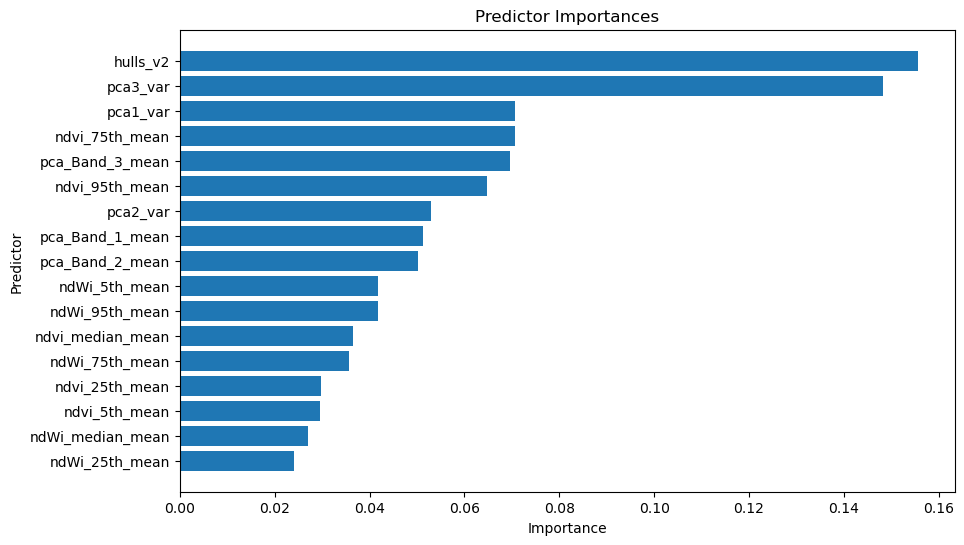

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

random_state = 42 # Set a random seed for reproducibility

predictor_cols = colnames

X = X_train
Y = y_train

print(X.shape, Y.shape)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=4, class_weight="balanced"))
])

# Parameters for the random search
params = {
    'classifier__n_estimators': randint(50, 1000),
    'classifier__max_features': randint(2, 50),
    'classifier__max_depth': randint(5, 25),
    'classifier__min_samples_split': randint(2,20),
    'classifier__min_samples_leaf': randint(2,20),
}

print("Optimising model")
rand_search = RandomizedSearchCV(pipeline, params, n_iter=50, cv=3, n_jobs=-1, random_state=random_state, verbose=1)

# Fit the model
rand_search.fit(X, Y)

print(f"Best parameters: {rand_search.best_params_}")

# Use the best pipeline from the random search
best_pipeline = rand_search.best_estimator_

# Manually set the best parameters from a previous run
# best_params = {'max_depth': 21, 'max_features': 9, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 338}

# # Create a pipeline with the best parameters
# best_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=42, **best_params))
# ])

# # Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba', average='weighted')
}

print("Cross-validating model")

# Perform cross-validation

iterations = 0
CV_Accuracy = []
CV_Balanced_Accuracy = []
CV_F1 = []
CV_AUC = []

# Use stratified k-fold cross-validation to avoid spatial autocorrelation
cv = StratifiedKFold(n_splits=5, shuffle=False)

# Cross-validate the model
cv_results = cross_validate(best_pipeline, X, Y, scoring=scoring, cv=cv)

# Print cross-validation results
print('CV Accuracy:', np.mean(cv_results['test_accuracy']))
print('CV Balanced Accuracy:', np.mean(cv_results['test_balanced_accuracy']))
print('CV F1 Score:', np.mean(cv_results['test_f1']))
print('Mean class CV AUC:', np.nanmean(cv_results['test_roc_auc']))

CV_Accuracy.append(np.mean(cv_results['test_accuracy']))
CV_Balanced_Accuracy.append(np.mean(cv_results['test_balanced_accuracy']))
CV_F1.append(np.mean(cv_results['test_f1']))
CV_AUC.append(np.nanmean(cv_results['test_roc_auc']))

# Fit the model on the entire dataset
best_pipeline.fit(X, Y)

# Extracting feature importances
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
most_important_feature = predictor_cols[feature_importances.argmax()]
importance_value = feature_importances.max()

# Sort feature importances from most to least
sorted_indices = feature_importances.argsort()[::-1]
sorted_predictors = [predictor_cols[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Invert the sorted lists to have the most important features on top
sorted_predictors = sorted_predictors[::-1]
sorted_importances = sorted_importances[::-1]

# Plot predictor importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Predictor Importances')
plt.show()

In [71]:
feature_importances

array([0.05921543, 0.04991783, 0.07644334, 0.01930343, 0.02701833,
       0.0238516 , 0.08412882, 0.05387031, 0.02609333, 0.0407873 ,
       0.01815312, 0.02808865, 0.04353904, 0.05835258, 0.14466652,
       0.07589273, 0.17067765])

In [66]:
feature_importances.argmax()

16

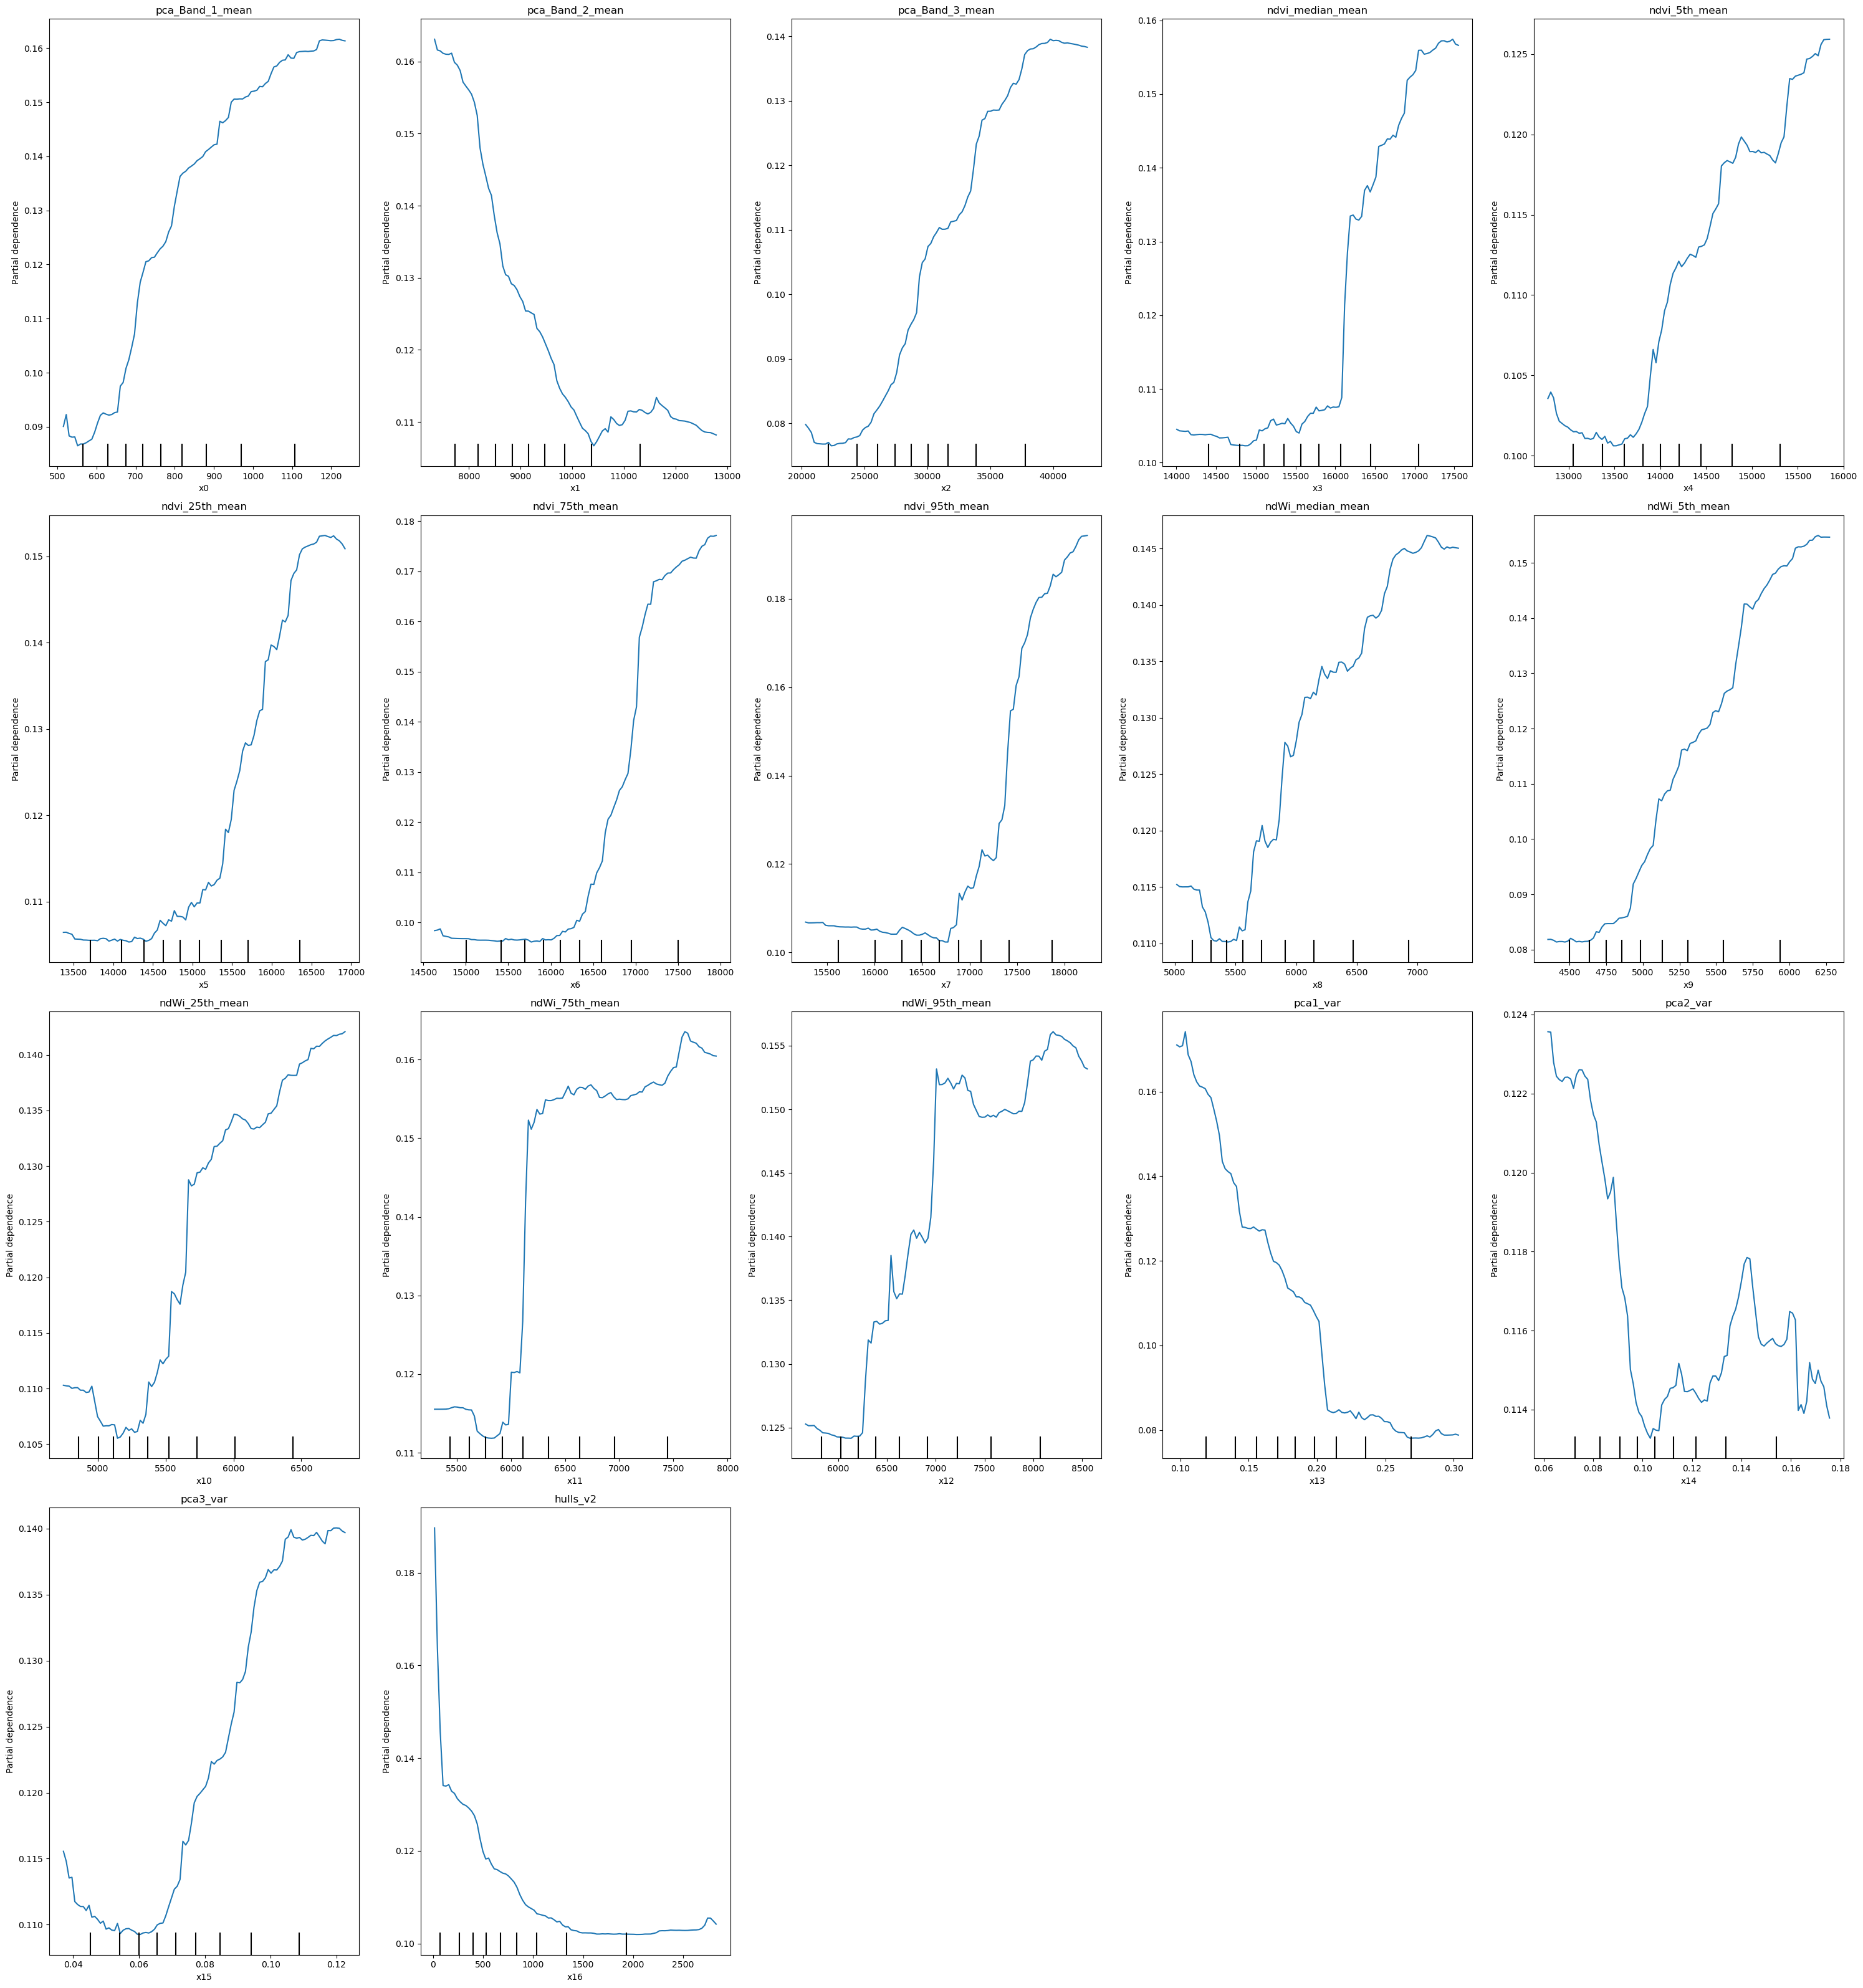

In [30]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# Calculate the number of rows needed for the grid
n_cols = 5
n_rows = math.ceil(len(predictor_cols) / n_cols)

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 8 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, col in enumerate(predictor_cols):
    # Plot the partial dependence
    pdp = PartialDependenceDisplay.from_estimator(best_pipeline, X, features=[i], ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(len(predictor_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

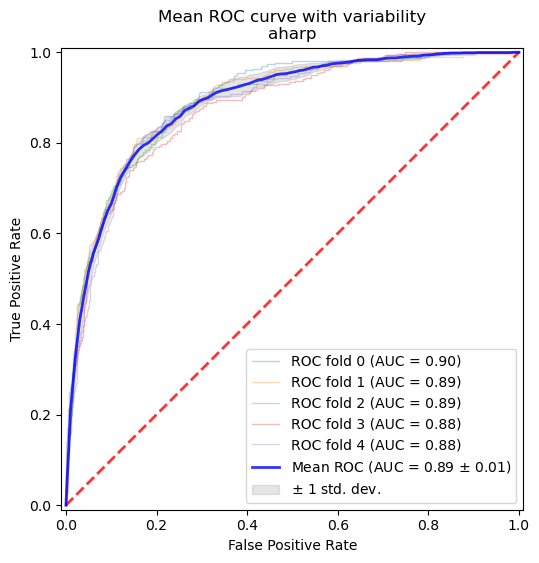

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

n_splits = 5


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, Y)):
    best_pipeline.fit(X[train], Y[train])
    viz = RocCurveDisplay.from_estimator(
        best_pipeline,
        X[test],
        Y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        # plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n{target_species}",
)
ax.legend(loc="lower right")
plt.show()

In [22]:
uq = np.unique(y_val, return_counts=True)  
print(uq)

(array([0., 1.]), array([3804210,  124614]))


F1 Score: 0.64
Accuracy: 0.86
Balanced Accuracy: 0.76
[[30661  2317]
 [ 3654  5371]]


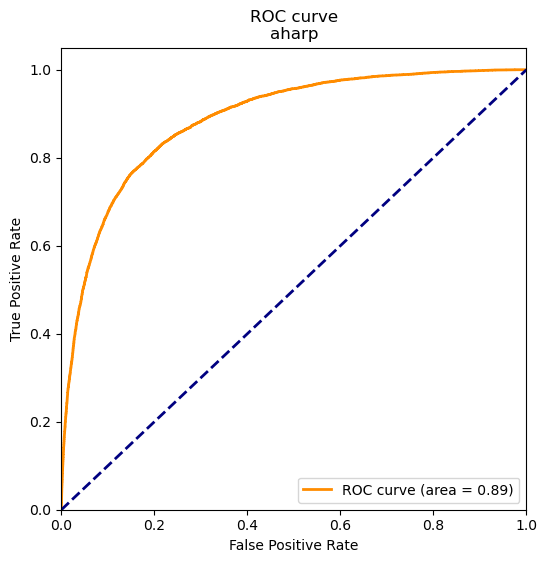

              precision    recall  f1-score   support

      Absent       0.89      0.93      0.91     32978
     Present       0.70      0.60      0.64      9025

    accuracy                           0.86     42003
   macro avg       0.80      0.76      0.78     42003
weighted avg       0.85      0.86      0.85     42003



In [18]:
from sklearn.metrics import confusion_matrix, classification_report


# Validate with the testing data
y_pred = best_pipeline.predict(X_val[:,0:num_predictors])
y_prob = best_pipeline.predict_proba(X_val[:,0:num_predictors])[:, 1]

# Print F1 score, accuracy, and balanced accuracy
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# print confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(cm)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve\n{target_species}')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print(classification_report(y_val, y_pred, target_names=["Absent", "Present"]))


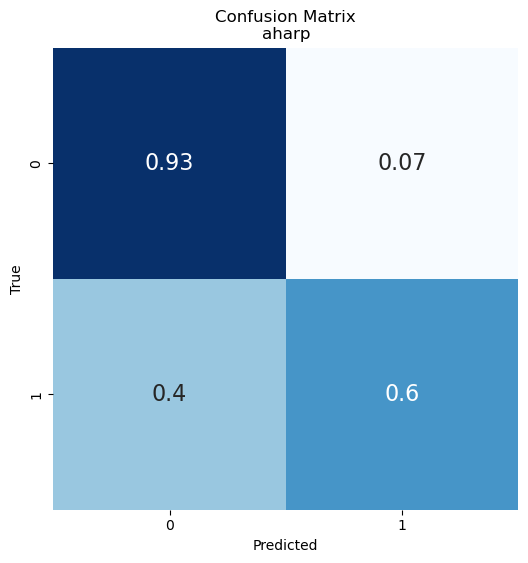

In [19]:
# Make a nicer confusion matrix
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')

# Create a heatmap from the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\n{target_species}')
plt.show()


In [10]:
# find best threshold from roc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y[test], best_pipeline.predict_proba(X[test])[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

optimal_threshold

NameError: name 'y' is not defined

In [20]:
variance_variables

'var'

In [21]:
# Make predictions on the full dataset
# Getting probabilities for all classes

# forest = rat.readColumn(RASTER_SEG, 'landcover_mode')

varray = []

for cols in colnames:
    varray.append(rat.readColumn(RASTER_SEG, cols))
    
presAbs = np.array(varray).T


pred_vars = presAbs[:,0:num_predictors]

probabilities = best_pipeline.predict_proba(pred_vars)

# Get the probabilities for class 1
class1_probabilities = probabilities[:, 1] * 100

# replace first row value with 255
class1_probabilities[0] = 255

# Write the probabilities to the RAT
rat.writeColumn(RASTER_SEG, f'{target_species}_{variance_variables}', class1_probabilities.astype(np.uint8))



In [22]:
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.var = RASTER_SEG.replace('.kea', f'{target_species}_{variance_variables}_final.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
setattr(otherargs, 'prob', 
            np.array(rat.readColumn(infiles.image, f'{target_species}_{variance_variables}')).astype(np.uint8))

otherargs.noData = 255
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(255)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

# conc = applier.ConcurrencyStyle(numReadWorkers=3,
#                                 numComputeWorkers=2,
#                                 computeWorkerKind="CW_THREADS",
#                                 readBufferPopTimeout=120,
#                                 computeBufferPopTimeout=120
#                                 )
# controls.setConcurrencyStyle(conc)

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = getattr(otherargs, 'prob')[data]
    outputs.var = rgb.reshape(inputs.image.shape).astype(np.uint8)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

Exporting Segmentation


## A harpophylla without diversity variables

CV Accuracy: 0.695
CV Balanced Accuracy: 0.695
CV F1 Score: 0.6926657528140221
Mean class CV AUC: 0.7461399999999999

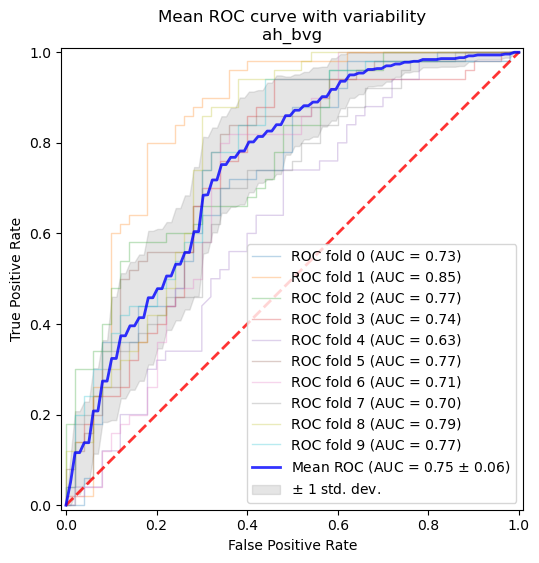

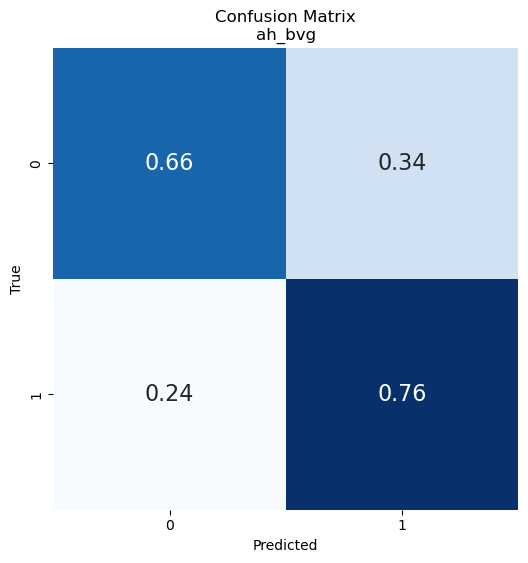

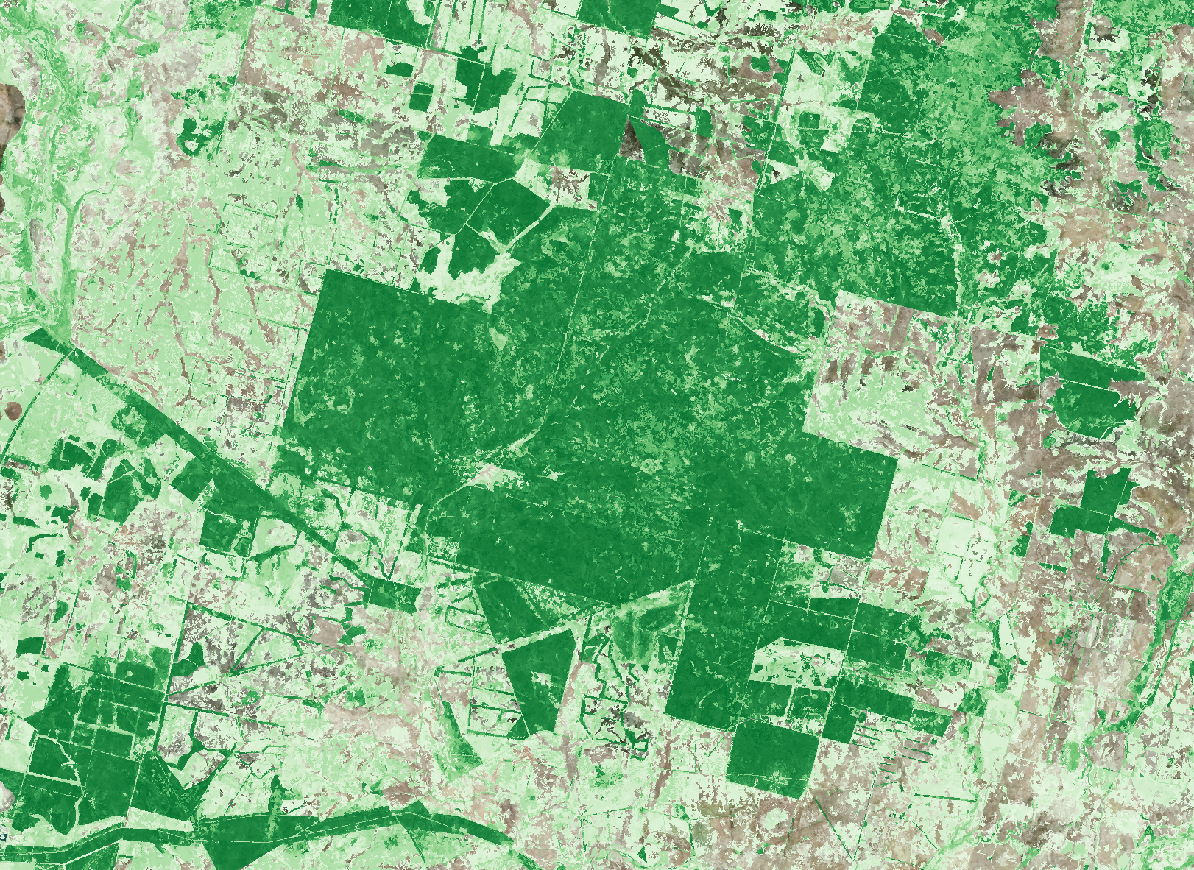


## A harpophylla with diversity variables

Cross-validating model
CV Accuracy: 0.8577142857142857
CV Balanced Accuracy: 0.7686027992646272
CV F1 Score: 0.8545116779630361
Mean class CV AUC: 0.8846565131586361

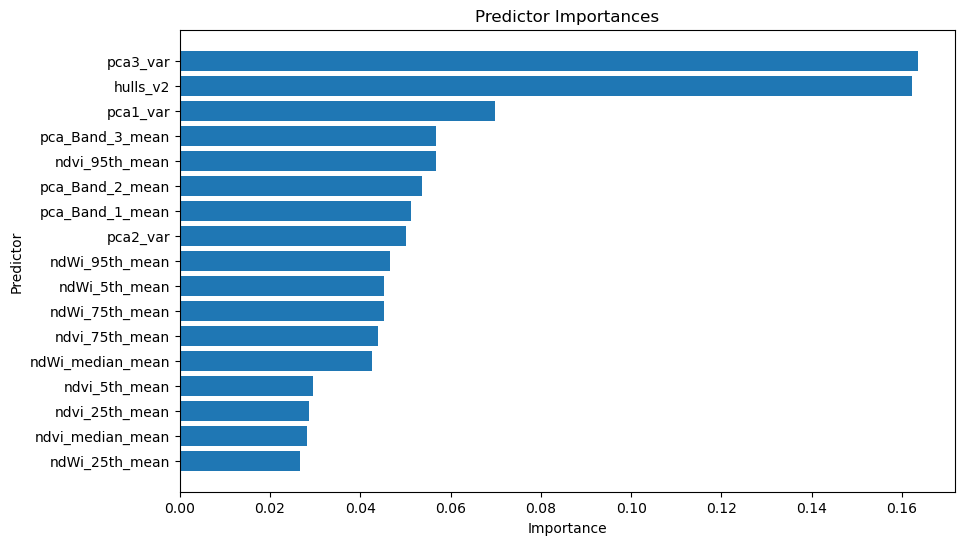

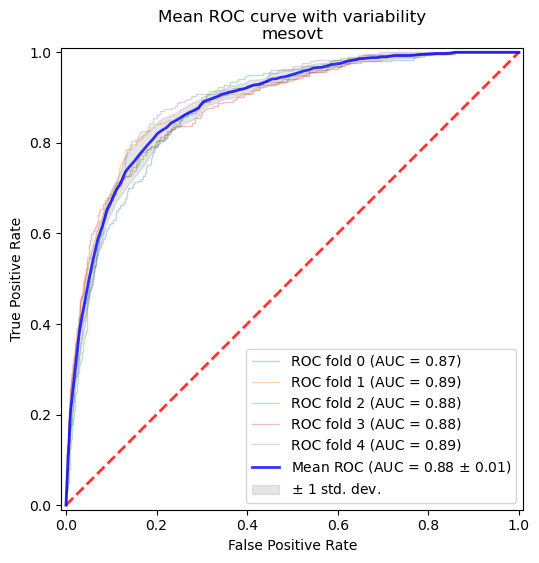

F1 Score: 0.64
Accuracy: 0.85
Balanced Accuracy: 0.76
[[30417  2561]
 [ 3557  5468]]

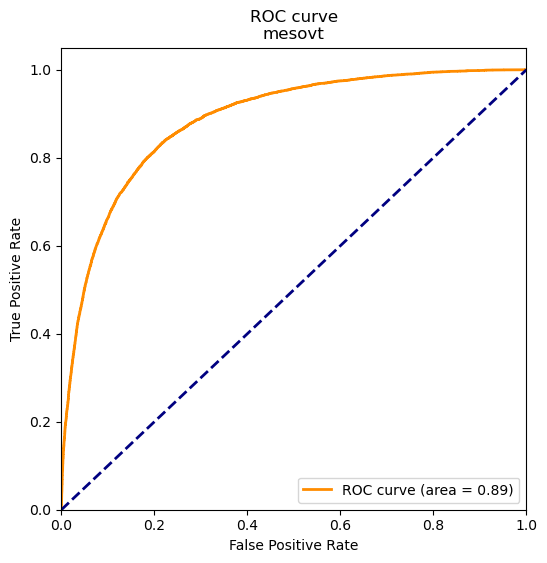

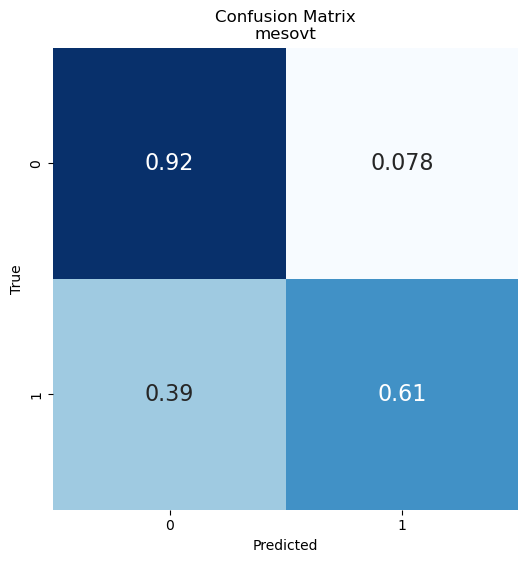

## Mesophyll vine thicket results - without diversity variables

Cross-validating model
CV Accuracy: 0.9340783429708397
CV Balanced Accuracy: 0.7274452808338159
CV F1 Score: 0.9298609514070144
Mean class CV AUC: 0.9077583954358708

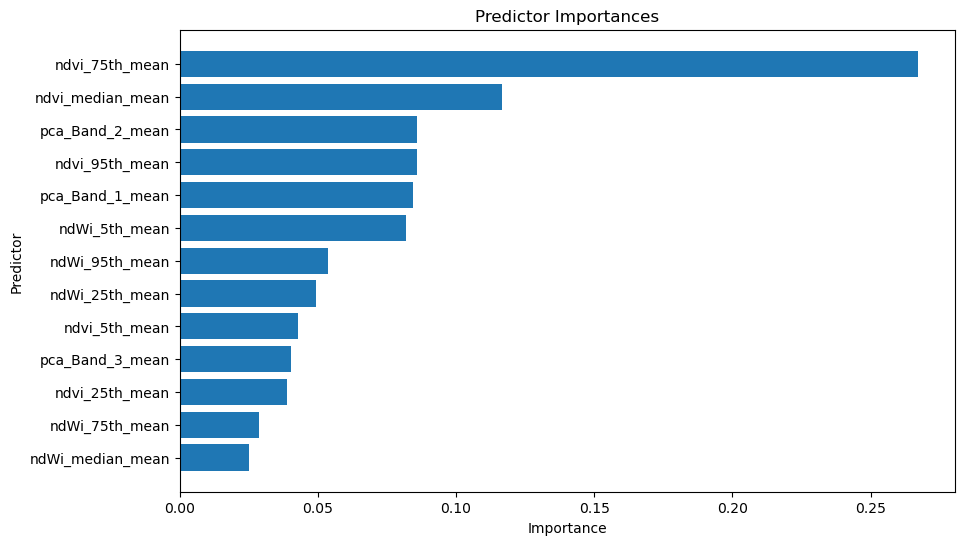

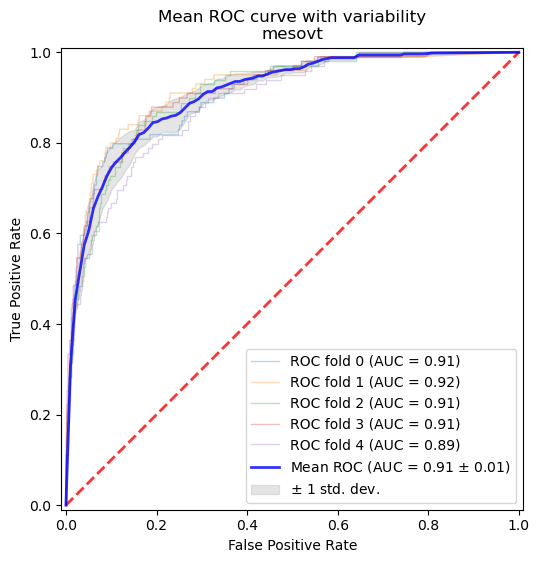

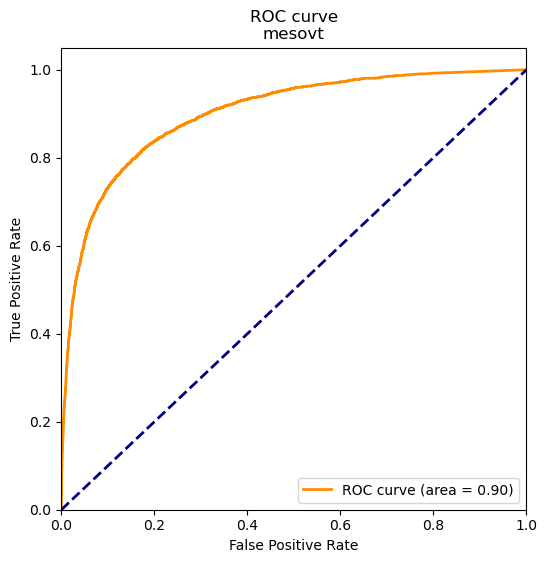

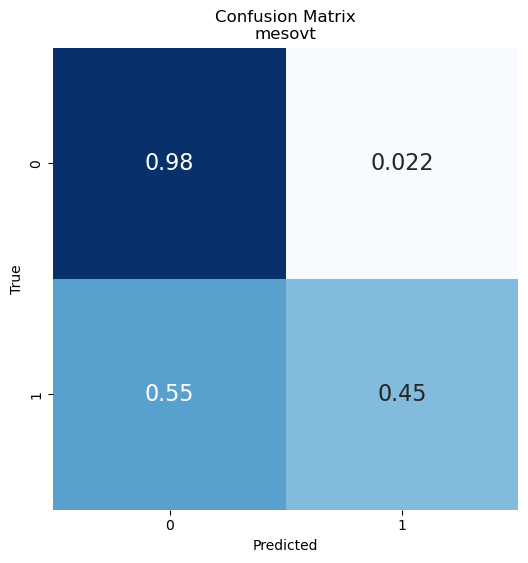

F1 Score: 0.53
Accuracy: 0.93
Balanced Accuracy: 0.71
[[32260   718]
 [ 1644  1331]]


## WITH diversity variables

Cross-validating model
CV Accuracy: 0.9314062497824425
CV Balanced Accuracy: 0.7250199630518102
CV F1 Score: 0.9275917006363189
Mean class CV AUC: 0.9182820921599151

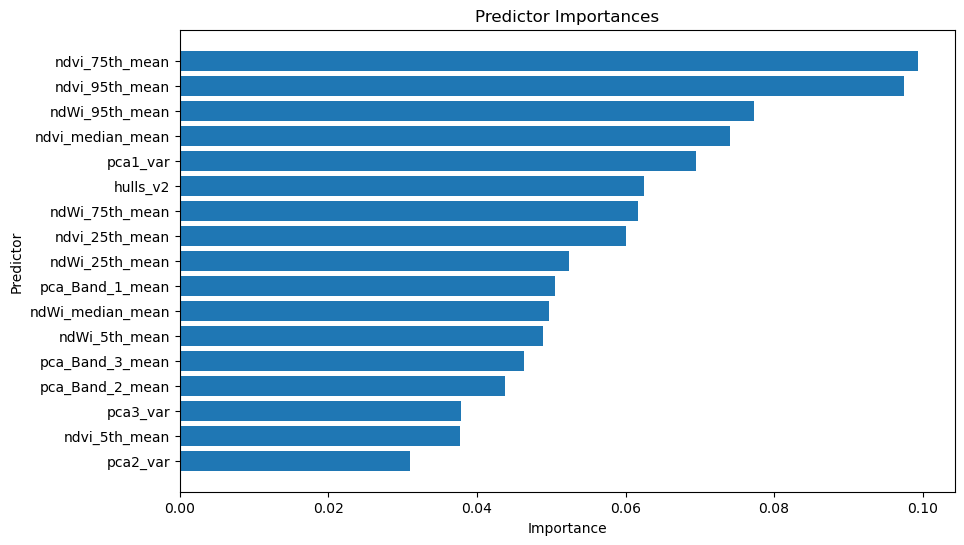

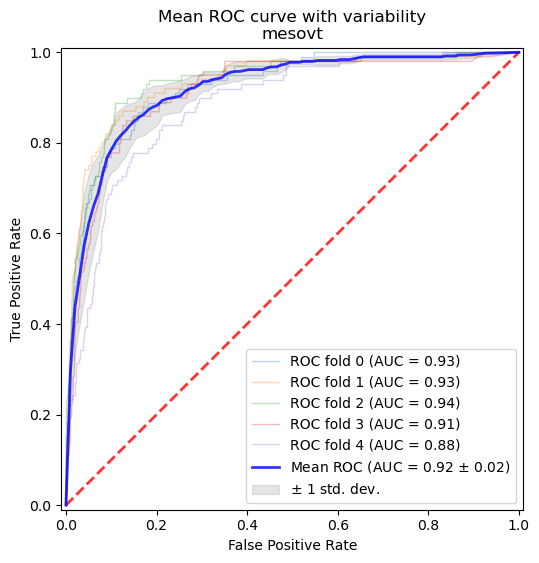

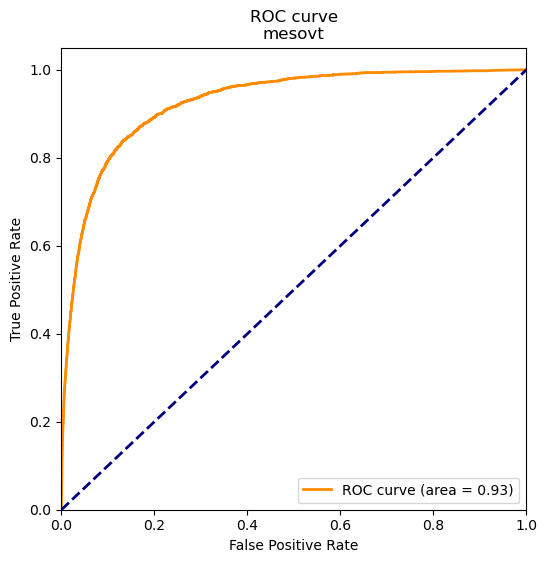

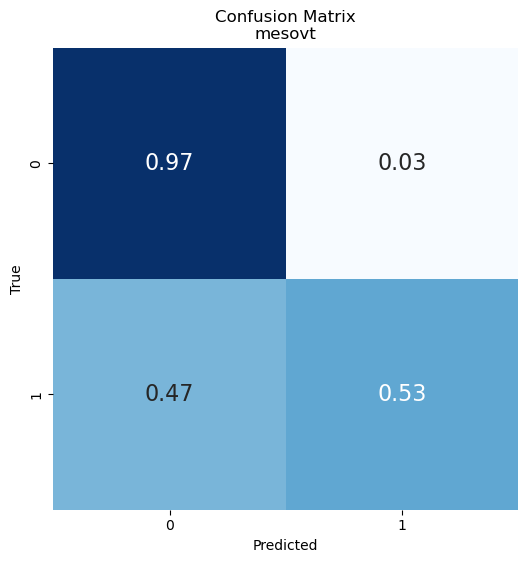


## Segment clustering test

In [10]:
# Use K-means clustering to find the optimal number of clusters

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

def exportCluster(info,inputs,outputs,otherargs):
    """
    RIOS applier function to write clusters.
    """   
    data = inputs.image
    inshape = data.shape
    data = np.reshape(data,-1)
    cluster = (otherargs.cluster)[data]
    outputs.cluster =  np.reshape(cluster,(1,inshape[1],inshape[2])).astype(np.uint8)

def ClusterSegments(RASTER_SEG, nClusters, writeTif=True):
    """
    Use minibatch kmeans to cluster by PCA bands
    """
    print(f'Clustering with {nClusters} classes')

    # Using list comprehension to create the list of wanted names
    wantedNames = ['pca_Band_1_mean', 'pca_Band_2_mean', 'pca_Band_3_mean',
            'ndvi_median_mean', 'ndvi_5th_mean', 'ndvi_25th_mean', 'ndvi_75th_mean', 
            'ndvi_95th_mean', 'ndWi_median_mean', 'ndWi_5th_mean', 'ndWi_25th_mean', 
            'ndWi_75th_mean','ndWi_95th_mean',
            'pca2_var', 'pca3_var', 'pca1_var', 'hulls_v2']   
        
    # Iterate for all the RAT columns
    segData = []
    for name in wantedNames:
        print("Extracting data from " + name)
        # Extract the array of values corresponding to the field site segments
        segData.append(rat.readColumn(RASTER_SEG,name).astype('float'))
    # Convert the list of arrays to an array and drop the first row
    segData = np.transpose(segData)[1:]
    # scale the data using a robust scaler
    scaler = RobustScaler().fit(segData)
    segData = scaler.transform(segData)
    # Print the shape of the data
    print(segData.shape)
    
    clustering = MiniBatchKMeans(n_clusters=nClusters, init='k-means++', reassignment_ratio=0.01, n_init=3).fit(segData)
    
    # Write cluster labels to RAT
    print('Writing clusters to RAT')
    rat.writeColumn(RASTER_SEG, f'clust{nClusters}', np.insert(clustering.labels_ + 1, 0, 0))
    
    # # Print some scores
    # silhouette_avg = silhouette_score(segData, clustering.labels_)
    
    # print(f'For n_clusters = {nClusters}, the average silhouette_score is : {silhouette_avg}')
    
    
    # Optionally write the clusters to a tif for visualisation
    if writeTif:
        
        print('Exporting Clusters')
        infiles = applier.FilenameAssociations()
        outfiles = applier.FilenameAssociations()   
        infiles.image = RASTER_SEG
        outfiles.cluster = RASTER_SEG.replace('.kea','_cluster.tif')

        otherargs = applier.OtherInputs()
        otherargs.cluster = np.round(rat.readColumn(infiles.image,f'clust{nClusters}')).astype(np.uint16)
        otherargs.noData = 0
        controls = applier.ApplierControls()
        controls.windowxsize = 512
        controls.windowysize = 512
        controls.setThematic = True
        controls.setStatsIgnore(0)
        controls.setOutputDriverName("GTIFF")
        controls.setCreationOptions(["COMPRESS=DEFLATE",
                                        "ZLEVEL=9",
                                        "BIGTIFF=YES",
                                        "TILED=YES",
                                        "INTERLEAVE=BAND",
                                        "NUM_THREADS=ALL_CPUS",
                                        "BLOCKXSIZE=512",
                                        "BLOCKYSIZE=512"])

        applier.apply(exportCluster, infiles, outfiles, otherargs, controls=controls)
        
        
ClusterSegments(RASTER_SEG, 10, writeTif=True)


Clustering with 10 classes
Extracting data from pca_Band_1_mean
Extracting data from pca_Band_2_mean
Extracting data from pca_Band_3_mean
Extracting data from ndvi_median_mean
Extracting data from ndvi_5th_mean
Extracting data from ndvi_25th_mean
Extracting data from ndvi_75th_mean
Extracting data from ndvi_95th_mean
Extracting data from ndWi_median_mean
Extracting data from ndWi_5th_mean
Extracting data from ndWi_25th_mean
Extracting data from ndWi_75th_mean
Extracting data from ndWi_95th_mean
Extracting data from pca2_var
Extracting data from pca3_var
Extracting data from pca1_var
Extracting data from hulls_v2
(936885, 17)
Writing clusters to RAT
Exporting Clusters
